In [1]:
from collections import defaultdict
import numpy as np
import scipy
import scipy.sparse as sps
import math
import matplotlib.pyplot as plt
import time
from sklearn.datasets import load_svmlight_file
import random
%matplotlib inline

# Support Vector Machines
## Classification Using SVM
Le lien pour les données https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/


Le problème d'optimisation des SVM est donné par :

$$\min_{w \in R^d} \  \sum_{i=1}^n \ell(y_i A_i^\top w) + \frac\lambda2 \|w\|^2$$

Où $\ell : R\rightarrow R$, $\ell(z) := \max\{0,1-z\}$ est la fonction de perte hinge.

Pour tout $i$, $1 \leq i \leq n$, le vecteur $A_i \in \mathbb{R}^d$ représente le $i$-ème exemple de données, et $y_i \in {\pm1}$ est l'étiquette correspondante.



$$ \max_{\boldsymbol{\alpha} \in R^n } \  \alpha^\top\boldsymbol{1} - \tfrac1{2\lambda} \alpha^\top Y A A^\top Y\alpha
 \text{    Tel que    $0\le \alpha_i \le 1  \ \forall i$}$$
  

où $Y := \mathop{\text{diag}}(y)$, et $A \in \mathbb{R}^{n \times d}$ contient les $n$ exemples de données en tant que colonnes.

Il est à noter que $w$ peut être dérivé de $\boldsymbol{\alpha}$ comme suit :
\begin{equation}
    w(\alpha) = \frac{1}{\lambda} A^\top Y \alpha.
\end{equation}

In [2]:
DATA_TRAIN_PATH = 'data/w1a'

A, y = load_svmlight_file(DATA_TRAIN_PATH)
A = A.toarray()
print(y.shape, A.shape)

(2477,) (2477, 300)


## Calcul des fonction de coût et prédiction

## Étapes de l'algorithme

1. **Choisir un point de départ** $ \mathbf{x}^{(0)} = (x_1^{(0)}, x_2^{(0)}, \ldots, x_n^{(0)}) $
2. **Répéter jusqu'à convergence** :
 - Pour chaque variable $ x_i $ (où $ i $ varie de 1 à $ n $) :
 1. Fixer toutes les variables sauf $ x_i $
 2. Minimiser la fonction $ f $ par rapport à $ x_i $ :
 $$
 x_i^{(k+1)} = \arg \min_{x_i} f(x_1^{(k)}, \ldots, x_{i-1}^{(k)}, x_i, x_{i+1}^{(k)}, \ldots, x_n^{(k)})
 $$
 3. Mettre à jour $ x_i $ :
 $$
 \mathbf{x}^{(k+1)} = (x_1^{(k)}, \ldots, x_{i-1}^{(k)}, x_i^{(k+1)}, x_{i+1}^{(k)}, \ldots, x_n^{(k)})
 $$
3. **Vérifier la convergence** : Si $ \|\mathbf{x}^{(k+1)} - \mathbf{x}^{(k)}\| < \epsilon $, arrêter l'algorithme.

## Détails de la mise à jour

- **Initialisation** : Choisir un point de départ $ \mathbf{x}^{(0)} $
- **Mise à jour pour chaque variable** :
 $$
 x_i^{(k+1)} = \arg \min_{x_i} f(x_1^{(k)}, \ldots, x_{i-1}^{(k)}, x_i, x_{i+1}^{(k)}, \ldots, x_n^{(k)})
 $$
- **Critère d'arrêt** : 
 $$
 \|\mathbf{x}^{(k+1)} - \mathbf{x}^{(k)}\| < \epsilon
 $$

## Exemple

Supposons que nous voulons minimiser la fonction $ f(x, y) = x^2 + y^2 $.

1. Choisir un point de départ $ (x^{(0)}, y^{(0)}) $
2. Minimiser par rapport à $ x $ :
 $$
 x^{(k+1)} = \arg \min_x (x^2 + (y^{(k)})^2) = 0
 $$
3. Minimiser par rapport à $ y $ :
 $$
 y^{(k+1)} = \arg \min_y ((x^{(k+1)})^2 + y^2) = 0
 $$
4. Répéter jusqu'à convergence.

## Mise à jour globale sous forme de gradient

L'équation globale de mise à jour sous forme de gradient pour chaque variable $ x_i $ est donnée par :
$$
x_i^{(k+1)} = x_i^{(k)} - \alpha \frac{\partial f}{\partial x_i}(\mathbf{x}^{(k)})
$$
où $ \alpha $ est le taux d'apprentissage.

In [5]:
def hinge_loss(y, A, w):
    """The hinge loss formula

    Args:
        y (_type_): _description_
        A (_type_): _description_
        w (_type_): _description_

    Returns:
        _type_: _description_
    """
    return np.maximum(1 - y * (A @ w), 0)

In [6]:
def calculate_primal_objective(y, A, w, lambda_):
    """compute the full cost (the primal objective), that is loss plus regularizer.
    A: the full dataset matrix, shape = (num_examples, num_features)
    y: the corresponding +1 or -1 labels, shape = (num_examples)
    w: shape = (num_features)
    """
    v = hinge_loss(y, A, w)
    return np.sum(v) + lambda_ / 2 * np.sum(w ** 2)

In [7]:
def accuracy(y1, y2):
    return np.mean(y1 == y2)

def prediction(A, w):
    return (A @ w > 0) * 2 - 1

def calculate_accuracy(y, A, w):
    """compute the training accuracy on the training set (can be called for test set as well).
    A: the full dataset matrix, shape = (num_examples, num_features)
    y: the corresponding +1 or -1 labels, shape = (num_examples)
    w: shape = (num_features)
    """
    predicted_y = prediction(A, w)
    return accuracy(predicted_y, y)

## Coordinate Descent (Ascent) for SVM

In [14]:
def project_to_box(tensor):
    return min(max(tensor, 0.0), 1.0)

def calculate_coordinate_update(y, A, lambda_, alpha, w, i):
    """compute a coordinate update (closed form) for coordinate i.
    A: the dataset matrix, shape = (num_examples, num_features)
    y: the corresponding +1 or -1 labels, shape = (num_examples)
    w: shape = (num_examples)
    i: the coordinate to be updated
    """        
    # calculate the update of coordinate at index=i.
    a_i, y_i = A[i], y[i]
    old_alpha_i = np.copy(alpha[i])
    
    alpha[i] = project_to_box(old_alpha_i + lambda_ * (1 - y_i * a_i.T @ w) / (a_i.T @ a_i))

    # compute the corresponding update on the primal vector w
    w += (1.0 / lambda_) * (alpha[i] - old_alpha_i) * y_i * a_i
    return w, alpha

In [15]:
def calculate_dual_objective(y, A, w, alpha, lambda_):
    """calculate the objective for the dual problem."""
    return np.sum(alpha)  - lambda_ / 2.0 * np.sum(w ** 2) # w = 1/lambda * A * Y * alpha

In [16]:
def coordinate_descent_for_svm_demo(y, A, trace=False):
    max_iter = 1000000
    lambda_ = 0.01
    history = defaultdict(list) if trace else None
    
    num_examples, num_features = A.shape
    w = np.zeros(num_features)
    alpha = np.zeros(num_examples)
    
    for it in range(max_iter):
        # i = sample one data point uniformly at random from the columns of A
        i = random.randint(0,num_examples-1)
        
        w, alpha = calculate_coordinate_update(y, A, lambda_, alpha, w, i)
            
        if it % 100000 == 0:
            # primal objective
            primal_value = calculate_primal_objective(y, A, w, lambda_)
            # dual objective
            dual_value = calculate_dual_objective(y, A, w, alpha, lambda_)
            # primal dual gap
            duality_gap = primal_value - dual_value
            
            print('iteration=%i, primal:%.5f, dual:%.5f, gap:%.5f'%(
                    it, primal_value, dual_value, duality_gap))
        if it % 1000 == 0:
            primal_value = calculate_primal_objective(y, A, w, lambda_)
            if trace:
                history["objective_function"] += [primal_value]
                history['iter'].append(it)

            
    print("training accuracy = {l}".format(l=calculate_accuracy(y, A, w)))
    return history

history_cd = coordinate_descent_for_svm_demo(y, A, trace=True)

iteration=0, primal:2382.62563, dual:0.00063, gap:2382.62500


C:\Users\mbial\AppData\Local\Temp\ipykernel_16696\2393578710.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  alpha[i] = project_to_box(old_alpha_i + lambda_ * (1 - y_i * a_i.T @ w) / (a_i.T @ a_i))


iteration=100000, primal:271.68995, dual:216.16840, gap:55.52155
iteration=200000, primal:247.51175, dual:221.42340, gap:26.08835
iteration=300000, primal:242.09677, dual:223.63027, gap:18.46650
iteration=400000, primal:244.64498, dual:224.66796, gap:19.97702
iteration=500000, primal:239.30841, dual:225.40082, gap:13.90759
iteration=600000, primal:234.88636, dual:225.98319, gap:8.90317
iteration=700000, primal:237.52157, dual:226.37221, gap:11.14937
iteration=800000, primal:234.56445, dual:226.78501, gap:7.77945
iteration=900000, primal:237.41942, dual:227.04896, gap:10.37046
training accuracy = 0.9951554299555915


# Stochastic gradient descent + SVM

Optimisons le SVM avec le SGD

In [8]:
def compute_stoch_gradient_svm(A_batch, b_batch, lambda_, w_t, num_data_points):
    z = A_batch.dot(w_t) * b_batch
    if z >= 1:
        gradient = lambda_ * w_t
    else:
        gradient = lambda_ * w_t - num_data_points * b_batch * A_batch
    return gradient.reshape(-1)

In [9]:
def stochastic_gradient_descent_svm_demo(A, b, gamma, batch_size=1, trace=False):
    history = defaultdict(list) if trace else None
    num_data_points, num_features = np.shape(A)
    max_iter = 1000000
    lambda_ = 0.01
    
    
    w_t = np.zeros(num_features)
    
    for current_iter in range(max_iter):
        i = random.randint(0,num_data_points - 1)
        b_batch, A_batch = b[i], A[i]
        gradient = compute_stoch_gradient_svm(A_batch, b_batch, lambda_, w_t, num_data_points)
        w_t = w_t - gamma * gradient
        if current_iter % 100000 == 0:
            primal_value = calculate_primal_objective(y, A, w_t, lambda_)
            print('iteration=%i, primal:%.5f'%(
                    current_iter, primal_value))
        if current_iter % 1000 == 0:
            primal_value = calculate_primal_objective(y, A, w_t, lambda_)
            if trace:
                history['objective_function'].append(primal_value)
                history['iter'].append(current_iter)
    print("training accuracy = {l}".format(l=calculate_accuracy(y, A, w_t)))
    return history


Try different stepsized and find the best one

In [10]:
history_sgd_3 = stochastic_gradient_descent_svm_demo(A, y, 1e-3, batch_size=1, trace=True)
history_sgd_4 = stochastic_gradient_descent_svm_demo(A, y, 1e-4, batch_size=1, trace=True)
history_sgd_5 = stochastic_gradient_descent_svm_demo(A, y, 1e-5, batch_size=1, trace=True)
history_sgd_6 = stochastic_gradient_descent_svm_demo(A, y, 1e-6, batch_size=1, trace=True)

iteration=0, primal:1037.45323
iteration=100000, primal:450.20977
iteration=200000, primal:385.50235
iteration=300000, primal:679.94169
iteration=400000, primal:336.14718
iteration=500000, primal:418.04981
iteration=600000, primal:376.45531
iteration=700000, primal:366.98180
iteration=800000, primal:371.88552
iteration=900000, primal:740.43295
training accuracy = 0.9761808639483246
iteration=0, primal:1589.25990
iteration=100000, primal:247.08053
iteration=200000, primal:242.08529
iteration=300000, primal:241.15176
iteration=400000, primal:242.60546
iteration=500000, primal:238.47803
iteration=600000, primal:239.09665
iteration=700000, primal:242.36761
iteration=800000, primal:236.75537
iteration=900000, primal:240.08743
training accuracy = 0.994751715785224
iteration=0, primal:2449.13377
iteration=100000, primal:277.29616
iteration=200000, primal:259.72148
iteration=300000, primal:253.36108
iteration=400000, primal:249.14938
iteration=500000, primal:245.49177
iteration=600000, primal:

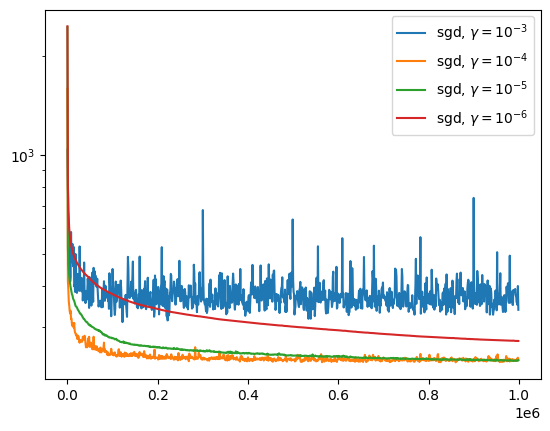

In [13]:
plt.semilogy(history_sgd_3["iter"], history_sgd_3["objective_function"], label="sgd, $\gamma = 10^{-3}$")
plt.semilogy(history_sgd_4["iter"], history_sgd_4["objective_function"], label="sgd, $\gamma = 10^{-4}$")
plt.semilogy(history_sgd_5["iter"], history_sgd_5["objective_function"], label="sgd, $\gamma = 10^{-5}$")
plt.semilogy(history_sgd_6["iter"], history_sgd_6["objective_function"], label="sgd, $\gamma = 10^{-6}$")
plt.legend()
plt.show()

La meilleure itération est $\gamma = 10^{-4}$.

# Comparaison SGD et coordinate 

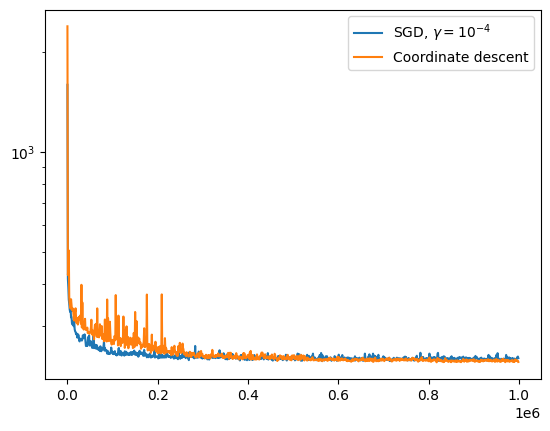

In [19]:
plt.semilogy(history_sgd_4["iter"], history_sgd_4["objective_function"], label="SGD, $\gamma = 10^{-4}$")
plt.semilogy(history_cd["iter"], history_cd["objective_function"], label="Coordinate descent")
plt.legend()
plt.show()

En termes de temps, la descente stochastique de gradient (SGD) et la descente par coordonnées ont les mêmes complexités temporelles par itération. Sur le graphique ci-dessus, la SGD avec le meilleur taux d'apprentissage converge à peu près à la même vitesse que la descente par coordonnées en termes d'itérations, tandis que la descente par coordonnées ne nécessite aucun ajustement de paramètres !